In [1]:
# ================================================================
# IMPORTS AND SETUP
# ================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from collections import defaultdict

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 5)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print("="*60)
print("DAY 11: MOE WITH LOAD BALANCING")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*60)

DAY 11: MOE WITH LOAD BALANCING
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
# ================================================================
# DATA LOADING
# ================================================================

def load_mnist(batch_size=64, data_dir='/kaggle/working/data'):
    """
    Load MNIST dataset
    """
    print("\nLoading MNIST Dataset...")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    
    return train_loader, test_loader

In [3]:
# ================================================================
# EXPERT & GATING (Same as 02_moe_simple)
# ================================================================

class Expert(nn.Module):
    """
    Single expert network
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.expert_id = None
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


class GatingNetwork(nn.Module):
    """
    Gating network with softmax routing
    """
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)
        self.num_experts = num_experts
        
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x, top_k=1):
        logits = self.fc(x)
        all_gates = F.softmax(logits, dim=1)
        top_gates, top_indices = torch.topk(all_gates, top_k, dim=1)
        top_gates = top_gates / (top_gates.sum(dim=1, keepdim=True) + 1e-10)
        
        return top_indices, top_gates, all_gates

In [4]:
# ================================================================
# MOE WITH LOAD BALANCING
# ================================================================

class BalancedMoE(nn.Module):
    """
    MoE with Load Balancing Loss (Switch Transformer)

    Key Addition: compute_load_balancing_loss()

    This penalizes uneven expert utilization

    Load Balancing Loss Formula:
        L_aux = num_experts * Σ(f_i * P_i)

    Where: 
        f_i = fraction of tokens routed to expert i (load)
        P_i = average gate probability for expert i (importance)

    Intuition: 
        - If the expert i gets high probability (P_i is high)
            And many token (f_i is high)
        - Then loss increases
        - Encourages spreading load across experts
    """
    def __init__(self, input_dim, num_experts=3, expert_hidden=64, 
                 output_dim=10, top_k=1):
        super(BalancedMoE, self).__init__()
        
        self.num_experts = num_experts
        self.top_k = top_k
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Create gating network
        self.gating = GatingNetwork(input_dim, num_experts)
        
        # Create experts
        self.experts = nn.ModuleList([
            Expert(input_dim, expert_hidden, output_dim)
            for i in range(num_experts)
        ])
        
        for i, expert in enumerate(self.experts):
            expert.expert_id = i
        
        # Track expert usage
        self.expert_counts = torch.zeros(num_experts)

    def forward(self, x):
        """
        Forward pass with load balancing.
        
        Returns:
            output: Model predictions
            aux_loss: Load balancing loss (NEW!)
        """
        batch_size = x.size(0)
        
        if x.dim() > 2:
            x = x.view(batch_size, -1)
        
        # Get gating decisions
        top_indices, top_gates, all_gates = self.gating(x, self.top_k)
        
        # Initialize output
        output = torch.zeros(batch_size, self.output_dim).to(x.device)
        
        # Route to experts (same as Day 10)
        for k in range(self.top_k):
            expert_idx = top_indices[:, k]
            gate_weight = top_gates[:, k]
            
            for expert_id in range(self.num_experts):
                mask = (expert_idx == expert_id)
                
                if mask.any():
                    expert_input = x[mask]
                    expert_output = self.experts[expert_id](expert_input)
                    output[mask] += gate_weight[mask].unsqueeze(1) * expert_output
                    self.expert_counts[expert_id] += mask.sum().item()
        
        # Compute load balancing loss
        aux_loss = self.compute_load_balancing_loss(all_gates, top_indices)
        
        return output, aux_loss

    def compute_load_balancing_loss(self, gates, top_indices):
        """
        Compute load balancing auxiliary loss

        From Switch Transformer (Fedus et al., 2022):

        Loss = num_experts * Σ(importance_i * load_i)

        Args:
            gates: (batch, num_experts) - softmax probabilities
            top_indices: (batch, top_k) - selected experts

        Returns:
            loss: Scalar tensor
        """
        # Importance: Average gate probability per expert
        # Basically -> "How much does the gating network want to use each expert?"
        importance = gates.mean(dim=0)

        # Load: Fraction of tokens routed to each expert
        # Basically -> "How many tokens actually went to each expert?"
        load = torch.zeros(self.num_experts).to(gates.device)

        for i in range(self.num_experts):
            # Count how many samples were routed to expert i
            mask = (top_indices == i).any(dim=1)
            load[i] = mask.float().mean()

        loss = self.num_experts * (importance * load).sum()

        return loss

    def count_parameters(self):
        """
        Count trainable parameters
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_expert_utilization(self):
        """
        Get expert utilization statistics
        """
        total = self.expert_counts.sum()
        if total == 0:
            percentages = [0.0] * self.num_experts
            entropy = 0.0
        else:
            percentages = (self.expert_counts / total * 100).tolist()
            probs = self.expert_counts / total
            entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
        
        return {
            'counts': self.expert_counts.tolist(),
            'percentages': percentages,
            'entropy': entropy,
            'max_usage': max(percentages) if percentages else 0,
            'min_usage': min(percentages) if percentages else 0
        }
    
    def reset_expert_counts(self):
        """Reset expert usage tracking."""
        self.expert_counts = torch.zeros(self.num_experts)

In [5]:
# ================================================================
# TRAINING WITH ALPHA COEFFICIENT
# ================================================================

def train_epoch_balanced(model, train_loader, optimizer, criterion, device, epoch, alpha=0.01):
    """
    Train with load balancing.
    
    Args:
        alpha: Load balancing coefficient
               - alpha=0: No load balancing (Day 10 behavior)
               - alpha=0.01: Gentle balancing
               - alpha=0.1: Strong balancing
               - alpha=1.0: Very strong (may hurt accuracy)
    """
    model.train()
    total_task_loss = 0
    total_aux_loss = 0
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} (α={alpha})')
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, aux_loss = model(data)
        
        # Task loss (classification)
        task_loss = criterion(output, target)
        
        # Total loss = task loss + alpha * load balancing loss
        total_loss_batch = task_loss + alpha * aux_loss
        
        # Backward
        total_loss_batch.backward()
        optimizer.step()
        
        # Track metrics
        total_task_loss += task_loss.item()
        total_aux_loss += aux_loss.item()
        total_loss += total_loss_batch.item()
        
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        pbar.set_postfix({
            'task': f'{task_loss.item():.4f}',
            'aux': f'{aux_loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    avg_task_loss = total_task_loss / len(train_loader)
    avg_aux_loss = total_aux_loss / len(train_loader)
    avg_total_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return avg_task_loss, avg_aux_loss, avg_total_loss, train_acc


def evaluate_balanced(model, test_loader, criterion, device):
    """
    Evaluate model
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


def train_with_load_balancing(model, train_loader, test_loader, 
                               epochs=10, lr=0.001, alpha=0.01, device='cuda'):
    """
    Complete training loop with load balancing.
    
    Args:
        alpha: Load balancing coefficient (KEY PARAMETER!)
    """
    print(f"\nTraining MoE with Load Balancing...")
    print(f"Model parameters: {model.count_parameters():,}")
    print(f"Number of experts: {model.num_experts}")
    print(f"Load balancing α: {alpha}")
    print(f"Device: {device}")
    print("-" * 60)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'task_loss': [],
        'aux_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'expert_utilization': [],
        'epoch_times': []
    }
    
    best_acc = 0
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        model.reset_expert_counts()
        
        # Train
        task_loss, aux_loss, total_loss, train_acc = train_epoch_balanced(
            model, train_loader, optimizer, criterion, device, epoch, alpha
        )
        
        # Evaluate
        test_loss, test_acc = evaluate_balanced(model, test_loader, criterion, device)
        
        # Get expert utilization
        util = model.get_expert_utilization()
        
        epoch_time = time.time() - start_time
        
        # Save history
        history['train_loss'].append(total_loss)
        history['task_loss'].append(task_loss)
        history['aux_loss'].append(aux_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['expert_utilization'].append(util)
        history['epoch_times'].append(epoch_time)
        
        # Print summary
        print(f"\n Epoch {epoch}/{epochs} Summary:")
        print(f"   Task Loss: {task_loss:.4f} | Aux Loss: {aux_loss:.4f} | Total: {total_loss:.4f}")
        print(f"   Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        print(f"   Expert Usage: {[f'{p:.1f}%' for p in util['percentages']]}")
        print(f"   Entropy: {util['entropy']:.3f} (target: ~1.10 for balanced)")
        print(f"   Time: {epoch_time:.1f}s")
        
        if test_acc > best_acc:
            best_acc = test_acc
            print(f"New best accuracy!")
        
        print("-" * 60)
    
    print("\nTraining Complete!")
    print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    
    final_util = history['expert_utilization'][-1]
    max_usage = max(final_util['percentages'])
    
    if max_usage > 80:
        print("COLLAPSED: One expert dominates!")
    elif max_usage < 40:
        print("BALANCED: Experts used equally!")
    else:
        print("SLIGHT IMBALANCE: Mostly balanced")
    
    return history


In [6]:
# ================================================================
# COMPARISON EXPERIMENT
# ================================================================

def run_comparison_experiment(train_loader, test_loader, device='cuda'):
    """
    Compare three configurations:
    1. No load balancing (α=0) 
    2. Gentle balancing (α=0.01)
    3. Strong balancing (α=0.1)
    """
    print("\n" + "="*60)
    print("EXPERIMENT: LOAD BALANCING COMPARISON")
    print("="*60)
    
    alphas = [0.0, 0.01, 0.1]
    results = {}
    
    for alpha in alphas:
        print(f"\n{'='*60}")
        print(f"Testing α = {alpha}")
        print(f"{'='*60}")
        
        # Create fresh model
        model = BalancedMoE(
            input_dim=784,
            num_experts=3,
            expert_hidden=64,
            output_dim=10,
            top_k=1
        )
        
        # Train
        history = train_with_load_balancing(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=10,
            lr=0.001,
            alpha=alpha,
            device=device
        )
        
        results[alpha] = {
            'history': history,
            'final_acc': history['test_acc'][-1],
            'final_util': history['expert_utilization'][-1]
        }
    
    return results

In [7]:
# ================================================================
# VISUALIZATION
# ================================================================

def plot_comparison(results, save_path='/kaggle/working/load_balancing_comparison.png'):
    """
    Plot comparison of different alpha values
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    alphas = sorted(results.keys())
    colors = ['red', 'blue', 'green']
    
    # Row 1: Individual alpha results
    for idx, alpha in enumerate(alphas):
        history = results[alpha]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        
        # Plot expert utilization
        ax = axes[0, idx]
        num_experts = len(history['expert_utilization'][0]['percentages'])
        
        for expert_id in range(num_experts):
            percentages = [
                util['percentages'][expert_id]
                for util in history['expert_utilization']
            ]
            ax.plot(epochs, percentages, marker='o', label=f'Expert {expert_id}', linewidth=2)
        
        ax.axhline(y=100/num_experts, color='black', linestyle='--', alpha=0.5, label='Balanced')
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Utilization (%)', fontsize=11)
        ax.set_title(f'α = {alpha}', fontsize=13, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])
    
    # Row 2: Comparisons
    # Accuracy comparison
    ax = axes[1, 0]
    for idx, alpha in enumerate(alphas):
        history = results[alpha]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        ax.plot(epochs, history['test_acc'], marker='o', label=f'α={alpha}',
                color=colors[idx], linewidth=2)
    ax.axhline(y=97.52, color='gray', linestyle='--', alpha=0.7, label='Baseline (97.52%)')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Test Accuracy (%)', fontsize=11)
    ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([95, 99])
    
    # Entropy comparison
    ax = axes[1, 1]
    for idx, alpha in enumerate(alphas):
        history = results[alpha]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        entropies = [util['entropy'] for util in history['expert_utilization']]
        ax.plot(epochs, entropies, marker='o', label=f'α={alpha}',
                color=colors[idx], linewidth=2)
    ax.axhline(y=1.10, color='black', linestyle='--', alpha=0.5, label='Perfect Balance')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Entropy', fontsize=11)
    ax.set_title('Entropy Comparison', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Final utilization bars
    ax = axes[1, 2]
    x = np.arange(3)
    width = 0.25
    
    for idx, alpha in enumerate(alphas):
        final_util = results[alpha]['final_util']
        offset = (idx - 1) * width
        ax.bar(x + offset, final_util['percentages'], width, 
               label=f'α={alpha}', color=colors[idx], alpha=0.8)
    
    ax.axhline(y=33.33, color='black', linestyle='--', alpha=0.5, label='Balanced')
    ax.set_xlabel('Expert ID', fontsize=11)
    ax.set_ylabel('Final Usage (%)', fontsize=11)
    ax.set_title('Final Expert Utilization', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Expert 0', 'Expert 1', 'Expert 2'])
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nComparison plot saved to: {save_path}")
    plt.show()


def print_comparison_summary(results, baseline_acc=97.52):
    """
    Print comparison summary table
    """
    print("\n" + "="*80)
    print("LOAD BALANCING COMPARISON SUMMARY")
    print("="*80)
    
    print(f"\n{'Alpha':<10} {'Accuracy':<12} {'Δ Baseline':<12} {'Entropy':<10} {'Max Usage':<12} {'Status':<15}")
    print("-" * 80)
    
    for alpha in sorted(results.keys()):
        final_acc = results[alpha]['final_acc']
        final_util = results[alpha]['final_util']
        
        delta = final_acc - baseline_acc
        entropy = final_util['entropy']
        max_usage = final_util['max_usage']
        
        if max_usage > 70:
            status = "Collapsed"
        elif max_usage < 40:
            status = "Balanced"
        else:
            status = "Slight imbalance"
        
        print(f"{alpha:<10.2f} {final_acc:<12.2f}% {delta:+11.2f}% {entropy:<10.3f} {max_usage:<12.1f}% {status:<15}")
    
    print("="*80)
    
    print("\nKey Insights:")
    print("   - α=0.0: Collapse likely ")
    print("   - α=0.01-0.1: Good balance without hurting accuracy")
    print("   - α>0.1: May force equality too much")
    
    print("\n" + "="*80)


Loading MNIST Dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 29.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


Training samples: 60,000
Test samples: 10,000

EXPERIMENT: LOAD BALANCING COMPARISON

Testing α = 0.0

Training MoE with Load Balancing...
Model parameters: 155,025
Number of experts: 3
Load balancing α: 0.0
Device: cuda
------------------------------------------------------------


Epoch 1 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 1/10 Summary:
   Task Loss: 0.3145 | Aux Loss: 1.3863 | Total: 0.3145
   Train Acc: 90.58% | Test Acc: 94.61%
   Expert Usage: ['64.7%', '21.1%', '14.3%']
   Entropy: 0.888 (target: ~1.10 for balanced)
   Time: 12.5s
New best accuracy!
------------------------------------------------------------


Epoch 2 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 2/10 Summary:
   Task Loss: 0.1475 | Aux Loss: 1.6627 | Total: 0.1475
   Train Acc: 95.55% | Test Acc: 95.66%
   Expert Usage: ['76.1%', '11.8%', '12.0%']
   Entropy: 0.715 (target: ~1.10 for balanced)
   Time: 11.8s
New best accuracy!
------------------------------------------------------------


Epoch 3 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():
     ^^^ ^ ^^ ^ ^ ^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  
    File "/usr/lib/p


 Epoch 3/10 Summary:
   Task Loss: 0.1367 | Aux Loss: 1.3535 | Total: 0.1367
   Train Acc: 95.83% | Test Acc: 95.23%
   Expert Usage: ['42.6%', '11.0%', '46.3%']
   Entropy: 0.963 (target: ~1.10 for balanced)
   Time: 12.7s
------------------------------------------------------------


Epoch 4 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>if w.is_alive():

 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
         self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^^^if w.is_alive():^
^ ^^ ^ ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'  
^ ^ ^  ^ ^  ^ ^ ^ ^ ^^^^^^
^  File "


 Epoch 4/10 Summary:
   Task Loss: 0.1099 | Aux Loss: 1.4937 | Total: 0.1099
   Train Acc: 96.67% | Test Acc: 96.24%
   Expert Usage: ['18.6%', '8.1%', '73.4%']
   Entropy: 0.743 (target: ~1.10 for balanced)
   Time: 12.4s
New best accuracy!
------------------------------------------------------------


Epoch 5 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 5/10 Summary:
   Task Loss: 0.0828 | Aux Loss: 1.7629 | Total: 0.0828
   Train Acc: 97.48% | Test Acc: 96.25%
   Expert Usage: ['15.7%', '3.5%', '80.8%']
   Entropy: 0.581 (target: ~1.10 for balanced)
   Time: 11.9s
New best accuracy!
------------------------------------------------------------


Epoch 6 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 6/10 Summary:
   Task Loss: 0.0709 | Aux Loss: 2.0100 | Total: 0.0709
   Train Acc: 97.84% | Test Acc: 96.64%
   Expert Usage: ['12.2%', '1.9%', '85.8%']
   Entropy: 0.464 (target: ~1.10 for balanced)
   Time: 11.9s
New best accuracy!
------------------------------------------------------------


Epoch 7 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 7/10 Summary:
   Task Loss: 0.0588 | Aux Loss: 1.6537 | Total: 0.0588
   Train Acc: 98.15% | Test Acc: 96.91%
   Expert Usage: ['21.8%', '3.4%', '74.8%']
   Entropy: 0.664 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------


Epoch 8 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 8/10 Summary:
   Task Loss: 0.0502 | Aux Loss: 1.7106 | Total: 0.0502
   Train Acc: 98.36% | Test Acc: 97.08%
   Expert Usage: ['17.9%', '3.9%', '78.3%']
   Entropy: 0.626 (target: ~1.10 for balanced)
   Time: 11.9s
New best accuracy!
------------------------------------------------------------


Epoch 9 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 9/10 Summary:
   Task Loss: 0.0441 | Aux Loss: 1.6260 | Total: 0.0441
   Train Acc: 98.63% | Test Acc: 97.05%
   Expert Usage: ['25.4%', '2.9%', '71.7%']
   Entropy: 0.689 (target: ~1.10 for balanced)
   Time: 11.6s
------------------------------------------------------------


Epoch 10 (α=0.0):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 10/10 Summary:
   Task Loss: 0.0369 | Aux Loss: 1.5422 | Total: 0.0369
   Train Acc: 98.79% | Test Acc: 97.06%
   Expert Usage: ['26.5%', '3.6%', '69.9%']
   Entropy: 0.721 (target: ~1.10 for balanced)
   Time: 11.7s
------------------------------------------------------------

Training Complete!
Final Test Accuracy: 97.06%
Best Test Accuracy: 97.08%
SLIGHT IMBALANCE: Mostly balanced

Testing α = 0.01

Training MoE with Load Balancing...
Model parameters: 155,025
Number of experts: 3
Load balancing α: 0.01
Device: cuda
------------------------------------------------------------


Epoch 1 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 1/10 Summary:
   Task Loss: 0.3150 | Aux Loss: 1.0287 | Total: 0.3253
   Train Acc: 90.39% | Test Acc: 94.37%
   Expert Usage: ['34.1%', '33.9%', '32.1%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.6s
New best accuracy!
------------------------------------------------------------


Epoch 2 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 2/10 Summary:
   Task Loss: 0.1619 | Aux Loss: 1.0317 | Total: 0.1722
   Train Acc: 95.06% | Test Acc: 95.38%
   Expert Usage: ['32.6%', '34.3%', '33.1%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------


Epoch 3 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 3/10 Summary:
   Task Loss: 0.1206 | Aux Loss: 1.0316 | Total: 0.1309
   Train Acc: 96.33% | Test Acc: 96.09%
   Expert Usage: ['33.3%', '33.4%', '33.3%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------


Epoch 4 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 4/10 Summary:
   Task Loss: 0.0999 | Aux Loss: 1.0305 | Total: 0.1102
   Train Acc: 96.94% | Test Acc: 96.33%
   Expert Usage: ['33.0%', '34.1%', '32.9%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------


Epoch 5 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    if w.is_alive():
              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self.


 Epoch 5/10 Summary:
   Task Loss: 0.0823 | Aux Loss: 1.0326 | Total: 0.0926
   Train Acc: 97.44% | Test Acc: 96.64%
   Expert Usage: ['33.0%', '33.8%', '33.2%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 15.5s
New best accuracy!
------------------------------------------------------------


Epoch 6 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive(): 
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700> 
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers() ^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^^ ^^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^ ^  ^^ ^^ 
   File "/usr/l


 Epoch 6/10 Summary:
   Task Loss: 0.0746 | Aux Loss: 1.0301 | Total: 0.0849
   Train Acc: 97.70% | Test Acc: 96.24%
   Expert Usage: ['33.5%', '34.0%', '32.5%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 13.7s
------------------------------------------------------------


Epoch 7 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 7/10 Summary:
   Task Loss: 0.0733 | Aux Loss: 1.0318 | Total: 0.0836
   Train Acc: 97.76% | Test Acc: 96.79%
   Expert Usage: ['32.9%', '32.5%', '34.6%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------


Epoch 8 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 8/10 Summary:
   Task Loss: 0.0621 | Aux Loss: 1.0301 | Total: 0.0724
   Train Acc: 98.09% | Test Acc: 96.87%
   Expert Usage: ['32.8%', '34.0%', '33.2%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.8s
New best accuracy!
------------------------------------------------------------


Epoch 9 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 9/10 Summary:
   Task Loss: 0.0590 | Aux Loss: 1.0338 | Total: 0.0693
   Train Acc: 98.11% | Test Acc: 97.01%
   Expert Usage: ['33.5%', '33.3%', '33.3%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.9s
New best accuracy!
------------------------------------------------------------


Epoch 10 (α=0.01):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 10/10 Summary:
   Task Loss: 0.0524 | Aux Loss: 1.0318 | Total: 0.0627
   Train Acc: 98.41% | Test Acc: 97.25%
   Expert Usage: ['33.3%', '33.0%', '33.6%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------

Training Complete!
Final Test Accuracy: 97.25%
Best Test Accuracy: 97.25%
BALANCED: Experts used equally!

Testing α = 0.1

Training MoE with Load Balancing...
Model parameters: 155,025
Number of experts: 3
Load balancing α: 0.1
Device: cuda
------------------------------------------------------------


Epoch 1 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 1/10 Summary:
   Task Loss: 0.3328 | Aux Loss: 1.0303 | Total: 0.4358
   Train Acc: 89.82% | Test Acc: 94.60%
   Expert Usage: ['32.9%', '33.8%', '33.3%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.8s
New best accuracy!
------------------------------------------------------------


Epoch 2 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 2/10 Summary:
   Task Loss: 0.1729 | Aux Loss: 1.0330 | Total: 0.2762
   Train Acc: 94.86% | Test Acc: 94.98%
   Expert Usage: ['34.1%', '32.0%', '33.9%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.9s
New best accuracy!
------------------------------------------------------------


Epoch 3 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 3/10 Summary:
   Task Loss: 0.1301 | Aux Loss: 1.0283 | Total: 0.2329
   Train Acc: 96.11% | Test Acc: 96.08%
   Expert Usage: ['33.3%', '33.5%', '33.2%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.8s
New best accuracy!
------------------------------------------------------------


Epoch 4 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 4/10 Summary:
   Task Loss: 0.1093 | Aux Loss: 1.0310 | Total: 0.2124
   Train Acc: 96.67% | Test Acc: 96.16%
   Expert Usage: ['34.3%', '32.5%', '33.1%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.7s
New best accuracy!
------------------------------------------------------------


Epoch 5 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 5/10 Summary:
   Task Loss: 0.0933 | Aux Loss: 1.0319 | Total: 0.1965
   Train Acc: 97.12% | Test Acc: 96.05%
   Expert Usage: ['33.4%', '34.0%', '32.6%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.7s
------------------------------------------------------------


Epoch 6 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 6/10 Summary:
   Task Loss: 0.0851 | Aux Loss: 1.0292 | Total: 0.1880
   Train Acc: 97.35% | Test Acc: 96.11%
   Expert Usage: ['32.8%', '32.6%', '34.6%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.7s
------------------------------------------------------------


Epoch 7 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive(): 
    ^^  ^  ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python


 Epoch 7/10 Summary:
   Task Loss: 0.0708 | Aux Loss: 1.0312 | Total: 0.1740
   Train Acc: 97.77% | Test Acc: 96.64%
   Expert Usage: ['33.2%', '33.0%', '33.8%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 15.3s
New best accuracy!
------------------------------------------------------------


Epoch 8 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ec3a4d56700> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^^ ^^ ^ ^  ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^   ^ ^ ^  ^^ ^ 
  File "/usr/


 Epoch 8/10 Summary:
   Task Loss: 0.0696 | Aux Loss: 1.0333 | Total: 0.1730
   Train Acc: 97.82% | Test Acc: 97.00%
   Expert Usage: ['33.1%', '32.3%', '34.6%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 13.6s
New best accuracy!
------------------------------------------------------------


Epoch 9 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 9/10 Summary:
   Task Loss: 0.0593 | Aux Loss: 1.0277 | Total: 0.1621
   Train Acc: 98.17% | Test Acc: 96.75%
   Expert Usage: ['32.8%', '32.7%', '34.5%']
   Entropy: 1.098 (target: ~1.10 for balanced)
   Time: 11.6s
------------------------------------------------------------


Epoch 10 (α=0.1):   0%|          | 0/938 [00:00<?, ?it/s]


 Epoch 10/10 Summary:
   Task Loss: 0.0581 | Aux Loss: 1.0325 | Total: 0.1613
   Train Acc: 98.17% | Test Acc: 96.16%
   Expert Usage: ['33.7%', '33.2%', '33.2%']
   Entropy: 1.099 (target: ~1.10 for balanced)
   Time: 11.7s
------------------------------------------------------------

Training Complete!
Final Test Accuracy: 96.16%
Best Test Accuracy: 97.00%
BALANCED: Experts used equally!

Comparison plot saved to: /kaggle/working/load_balancing_comparison.png


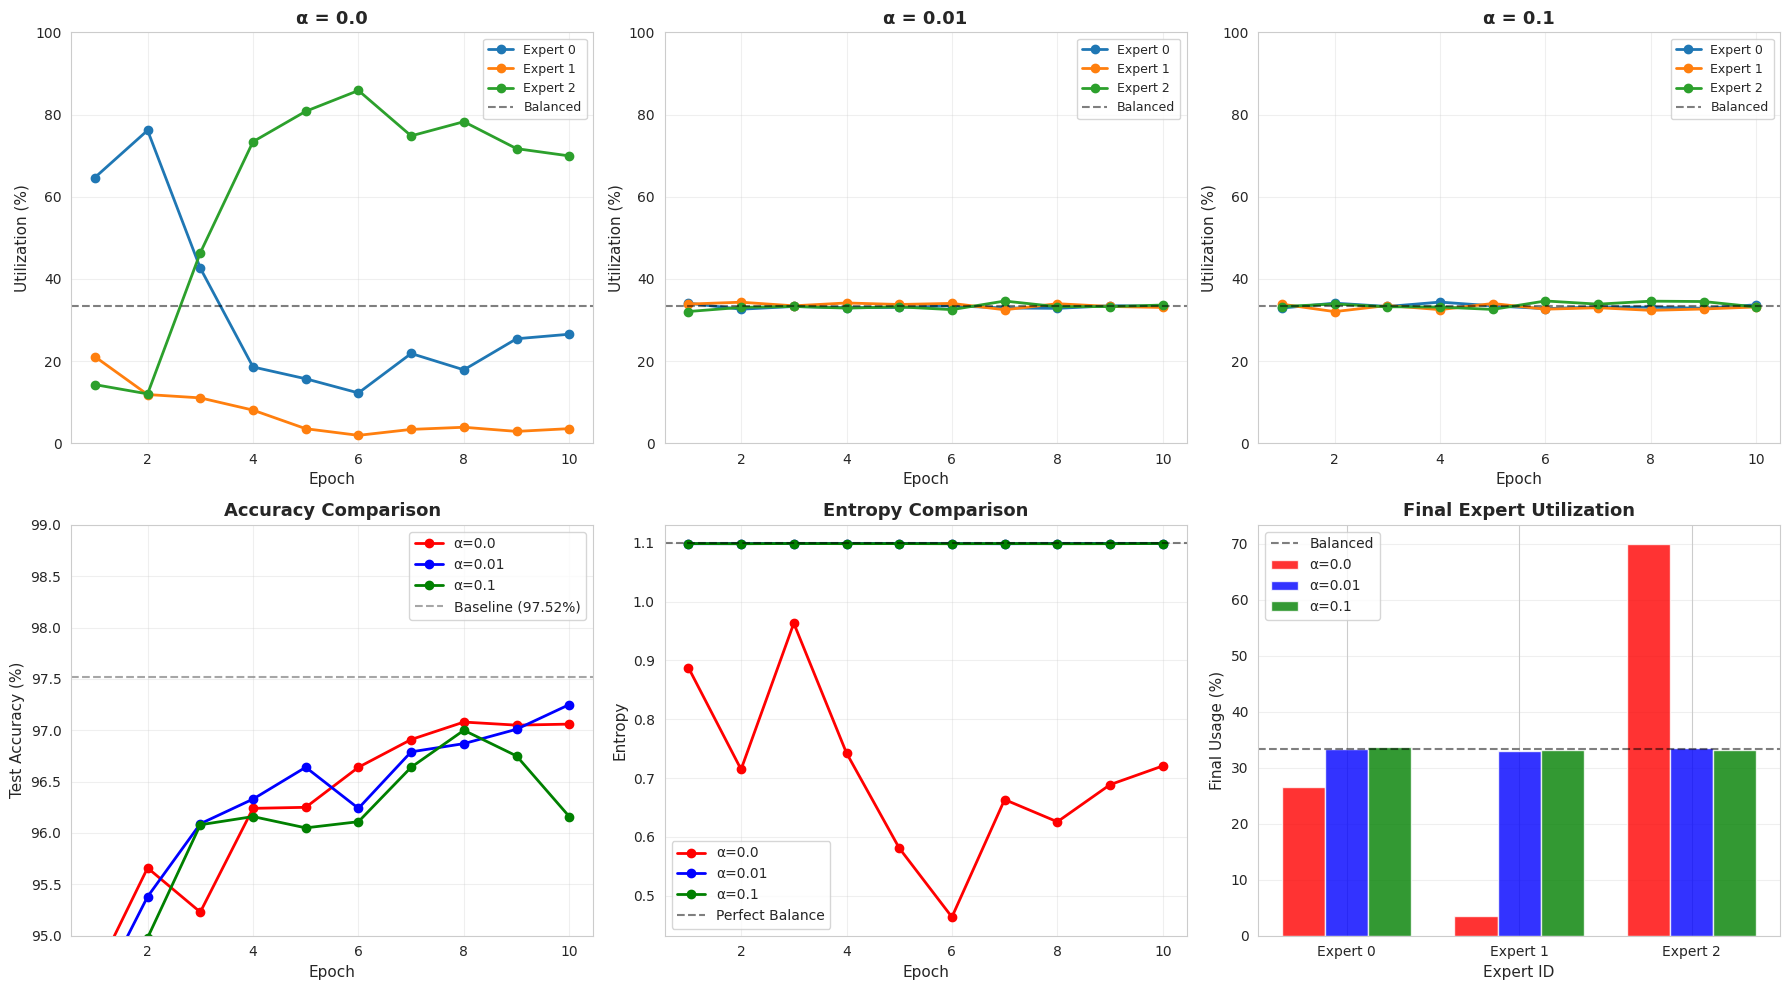


LOAD BALANCING COMPARISON SUMMARY

Alpha      Accuracy     Δ Baseline   Entropy    Max Usage    Status         
--------------------------------------------------------------------------------
0.00       97.06       %       -0.46% 0.721      69.9        % Slight imbalance
0.01       97.25       %       -0.27% 1.099      33.6        % Balanced       
0.10       96.16       %       -1.36% 1.099      33.7        % Balanced       

Key Insights:
   - α=0.0: Collapse likely 
   - α=0.01-0.1: Good balance without hurting accuracy
   - α>0.1: May force equality too much


Results saved!


In [8]:
# ================================================================
# MAIN EXECUTION
# ================================================================

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64

# Load data
train_loader, test_loader = load_mnist(batch_size=BATCH_SIZE)

# Run comparison experiment
results = run_comparison_experiment(train_loader, test_loader, device=DEVICE)

# Visualize
plot_comparison(results)

# Summary
print_comparison_summary(results, baseline_acc=97.52)

# Save best model (α=0.01 typically best)
best_alpha = 0.01
best_model_state = results[best_alpha]['history']

torch.save({
    'results': results,
    'best_alpha': best_alpha
}, '/kaggle/working/load_balancing_results.pth')

print(f"\nResults saved!")